# In this Jupyter notebook I will analyse the data from the microarray dataset of Linder et al about CKM mutants 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
root = "/Users/bencekover/Library/CloudStorage/OneDrive-Personal/MSci Bahler lab/S.-Pombe-MLPs - Github/"

plt.rcParams["font.family"] = "Arial"

In [2]:
#/Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Linder et al 2008/nar_gkn070_Expression_data_sup_mat.txt
data = pd.read_table(root + 'external data/Linder et al 2008/nar_gkn070_Expression_data_sup_mat.txt', sep='\t', header=0,encoding='latin-1')
#keep Gene_Symbol, log2_ratio_cdk8mut, log2_ratio_Æmed12
full_data = data.copy()
data = data[['Gene_Symbol','log2_ratio_cdk8mut','log2_ratio_Æmed12']]
#rename to gene, srb10, med12
data = data.rename(columns={'Gene_Symbol':'systematic','log2_ratio_cdk8mut':'srb10','log2_ratio_Æmed12':'med12'})
#make subset where rows of srb10 and med12 are either both positive or both negative and absolute value larger than 1
subset = data[(data['srb10'] > 1) & (data['med12'] > 1) | (data['srb10'] < -1) & (data['med12'] < -1)]
#sort by srb10
subset = subset.sort_values(by=['srb10'])
subset

,systematic,srb10,med12
1998,SPAC869.04,-5.400000,-4.966667
1997,SPAC869.03c,-3.677778,-4.277778
4079,SPBPJ4664.02,-2.333333,-2.411111
3824,SPBC800.11,-2.244444,-2.588889
30,SPAC1039.01,-2.122222,-1.700000
...,...,...,...
4047,SPBPB10D8.03,3.988889,4.211111
4045,SPBPB10D8.01,4.111111,3.966667
3938,SPBCPT2R1.08c,4.111111,3.988889
4046,SPBPB10D8.02c,4.466667,4.177778


In [3]:
#import our own flocculation correlation data /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/Bence folder/Analysis of Clement-Ziza RNA-seq/filter_corr.csv
data2 = pd.read_csv(root + "Bence folder/Analysis of Clement-Ziza RNA-seq/DESeq2/DE_results.csv")
data2 = data2.rename(columns={'Unnamed: 0':'systematic'})
data2 = data2[['systematic','log2FoldChange','padj']]
#import gene name map /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/gene_IDs_names_products.tsv
gene_map = pd.read_csv(root + "external data/Pombase files/gene_IDs_names_products.tsv", sep='\t', header=None)
#keep column 0,2,4, rename to systematic, gene, function
gene_map = gene_map[[0,2,4]]
gene_map = gene_map.rename(columns={0:'systematic',2:'gene',4:'function'})
#merge with our data on systematic
data = pd.merge(data,gene_map,how='left',on='systematic')
data2 = pd.merge(data2,gene_map,how='left',on='systematic')

In [4]:
#in data where gene is NaN, replace with systematic
data['gene'] = data['gene'].fillna(data['systematic'])
data2['gene'] = data2['gene'].fillna(data2['systematic'])
#final is merge data with data2 on gene
final = pd.merge(data,data2,how='left',on='gene')
#remove rows with nan
#remove np.inf from the whole dataframe
final = final.replace([np.inf, -np.inf], np.nan)
final = final.dropna()
#save to xlsx
final.to_excel(root + "Bence folder/Analysis of Linder et al data/Full_DE_results_CKM_deletions.xlsx")


{'SPBPJ4664.02', 'SPCC285.05', 'mcp7'}


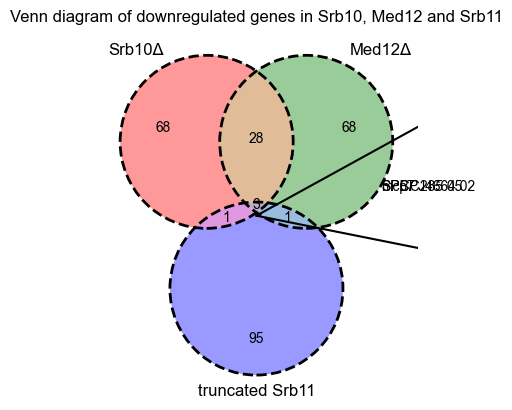

In [5]:
#same with downregulated
srb10_down = list(final.sort_values(by=['srb10'],ascending=True)['gene'].head(100))
med12_down = list(final.sort_values(by=['med12'],ascending=True)['gene'].head(100))
srb11_down = list(final[(final['log2FoldChange'] < 0) & (final['padj'] < 0.1)].sort_values(by=['log2FoldChange'],ascending=True)['gene'].head(100))

print(set(srb10_down).intersection(set(med12_down)).intersection(set(srb11_down)))
shared = set(srb10_down).intersection(set(med12_down)).intersection(set(srb11_down))
shared = list(shared)

from matplotlib_venn import venn3_circles, venn3
venn3([set(srb10_down), set(med12_down), set(srb11_down)], set_labels = ('Srb10Δ', 'Med12Δ', 'truncated Srb11'))
venn3_circles([set(srb10_down), set(med12_down), set(srb11_down)], linestyle='dashed')
plt.title('Venn diagram of downregulated genes in Srb10, Med12 and Srb11')
for i,j in enumerate(shared):
      plt.text(0.5,0,j,fontsize=10)
plt.plot([0,2],[-0.1,1],color='black')
plt.plot([0,2],[-0.1,-0.5],color='black')
plt.show()


{'frg1', 'inv1', 'SPAC4H3.08', 'SPAC27D7.09c', 'pfl8', 'SPAPB24D3.07c', 'pfl3', 'gsf2', 'SPAPB15E9.02c', 'SPAC56F8.13', 'mbx2', 'pfl9', 'psu2', 'shu1', 'spo6'}


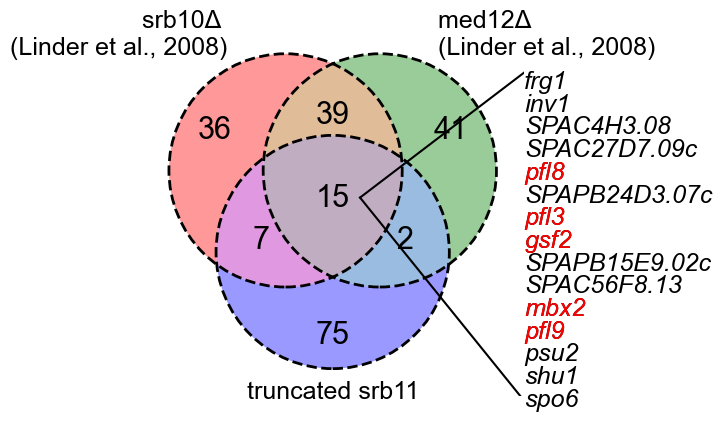

In [6]:
#create a list of top 100 upregulated genes in srb10, med12 and srb11
srb10_up = list(final.sort_values(by=['srb10'],ascending=False)['gene'].head(100))
med12_up = list(final.sort_values(by=['med12'],ascending=False)['gene'].head(100))
#srb11 up is log2fc > 1 and p < 0.05
srb11_up = list(final[(final['log2FoldChange'] > 0.5) & (final['padj'] < 0.05)].sort_values(by=['padj'],ascending=True)['gene'].head(100))
#print genes in intersection of all three lists
print(set(srb10_up).intersection(set(med12_up)).intersection(set(srb11_up)))
shared = set(srb10_up).intersection(set(med12_up)).intersection(set(srb11_up))
#turn this set into a list
shared = list(shared)
shared_saved_later = shared.copy()
#make a venn diagram of the three lists

from matplotlib_venn import venn3_circles, venn3, venn3_unweighted
v = venn3_unweighted([set(srb10_up), set(med12_up), set(srb11_up)], set_labels = ('srb10Δ \n(Linder et al., 2008)', 'med12Δ \n(Linder et al., 2008)', 'truncated srb11'))
venn3_circles((1,1,1,1,1,1,1), linestyle='dashed')

for text in v.set_labels:
  text.set_fontsize(18)

for text in v.subset_labels:
  text.set_fontsize(22)


#print strings of gene names in the intersection of the plot
for i,j in enumerate(shared):
    #put it on the plot
      plt.text(0.7,0.4-i*0.083,j,fontsize=18,style='italic')
      #if it has pfl of gsf or mbx in name then print with red
      if 'pfl' in j or 'gsf' in j or 'mbx' in j:
              plt.text(0.7,0.4-i*0.083,j,fontsize=18,color='red',style='italic')
#draw lines expanding the middle intersection
plt.plot([0.1,2.2],[0,1.6],color='black')
plt.plot([0.1,2.2],[0,-2.6],color='black')





#save as svg', format='svg',dpi=400) and png
plt.savefig(root + 'Figures/All figures/srb10_med12_srb11_venn.svg', format='svg',dpi=400)
plt.savefig(root + 'Figures/All figures/srb10_med12_srb11_venn.png', format='png',dpi=400)

In [7]:
# Save genes for Enrichment analysis with Angeli
#create a list of top 100 upregulated genes in srb10, med12 and srb11
srb10_up = list(final.sort_values(by=['srb10'],ascending=False)['systematic_x'].head(200))
med12_up = list(final.sort_values(by=['med12'],ascending=False)['systematic_x'].head(200))
#srb11 up is log2fc > 1 and p < 0.05
srb11_up = list(final[(final['log2FoldChange'] > 0.5) & (final['padj'] < 0.1)].sort_values(by=['padj'],ascending=True)['systematic_x'].head(200))
#print genes in intersection of all three lists
print(set(srb10_up).intersection(set(med12_up)).intersection(set(srb11_up)))
shared = set(srb10_up).intersection(set(med12_up)).intersection(set(srb11_up))
#turn this set into a list
shared = list(shared)
shared_saved = shared.copy()


#export as cdk8_angeli
cdk8_angeli = pd.DataFrame(shared)
cdk8_angeli.to_csv(root + 'Bence folder/Angeli/cdk8_angeli_recent.txt', index=False, header=False)
#export genes that are found in final systematic which is the background for angeli
final_sys = final['systematic_x']
final_sys.to_csv(root + 'Bence folder/Angeli/cdk8_background_recent.txt', index=False, header=False)


{'SPAC1F8.06', 'SPBC1105.13c', 'SPBC947.04', 'SPAC4H3.08', 'SPAC186.01', 'SPBC776.16', 'SPCC132.04c', 'SPBC19C7.04c', 'SPBC1773.06c', 'SPBC1778.04', 'SPCC191.01', 'SPBC1289.14', 'SPBC3E7.02c', 'SPBP23A10.12', 'SPAPB15E9.02c', 'SPAC56F8.13', 'SPAC1F8.02c', 'SPBPB21E7.01c', 'SPAC1751.01c', 'SPBC359.04c', 'SPBC2G2.17c', 'SPAC5D6.09c', 'SPACUNK4.17', 'SPAC27D7.09c', 'SPBC317.01', 'SPAPB24D3.07c', 'SPCC191.11', 'SPAC1F8.04c', 'SPAC3G6.07', 'SPCC1742.01', 'SPAC1F8.03c'}


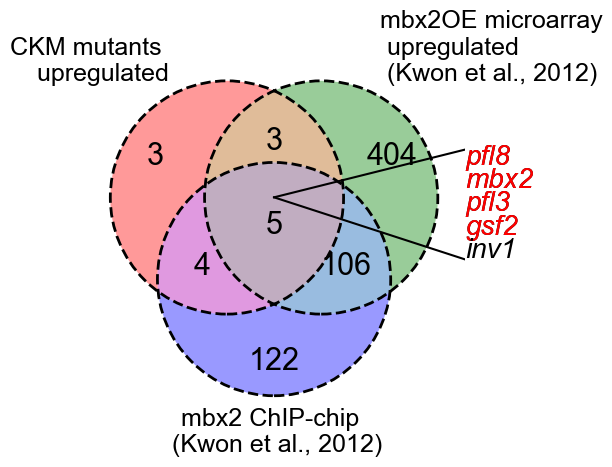

In [8]:
#load mbx2 data from kwon /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Kwon et al. 2012/pgen.1003104.s003.xlsx
mbx2 = pd.read_excel(root + 'external data/Kwon et al. 2012/pgen.1003104.s003.xlsx',  header=1)
#find shared_saved genes in final and output the systematic name for thgose rows in a list
#add bonferroni correction to p values
mbx2["bonferroni"]=mbx2["mbx2OE p-value"]*len(mbx2["mbx2OE p-value"])
systematics = []
for i in final['gene']:
      if i in shared_saved_later:
            
            systematics.append(final[final['gene'] == i]['systematic_x'].values[0])

#load mbx2_chipseq /Users/bencekover/Library/CloudStorage/OneDrive-UniversityCollegeLondon/MSci Bahler lab/S.-Pombe-biofilm/external data/Kwon et al. 2012/pgen.1003104.s004.xlsx
mbx2_chipseq = pd.read_excel(root + 'external data/Kwon et al. 2012/pgen.1003104.s004.xlsx',  header=1)
#find shared_saved genes in final and output the systematic name for thgose rows in a list
#add bonferroni correction to p values

#take the list of mbx2 Systematic Names where mbx2OE Log2 Fold Change >1 and mbx2OE p-value < 0.0001
mbx2_hits = list(mbx2[(mbx2['mbx2OE Log2 Fold Change'] > 1) & (mbx2['bonferroni'] < 5*10**-2)]['Systematic Name']) 
mbx2_hits_chip = mbx2_chipseq['Systematic Name']
#create venn2 of systematics and mbx2_hits and their overlap
#import venn2
from matplotlib_venn import venn3_circles
#set figsize
overlap = set(systematics).intersection(set(mbx2_hits)).intersection(set(mbx2_hits_chip))
#map overlap back to genes in final
overlap = final[final['systematic_x'].isin(overlap)]['gene']
#show the two sets and their overlap
#size of circles not proportional but same

v=venn3_unweighted([set(systematics), set(mbx2_hits_chip),set(mbx2_hits), ], set_labels = ('CKM mutants \n  upregulated', 'mbx2OE microarray\n upregulated \n (Kwon et al., 2012)', 'mbx2 ChIP-chip \n (Kwon et al., 2012)'))
venn3_circles((1,1,1,1,1,1,1), linestyle='dashed')
#print strings of gene names in the intersection of the plot
for i,j in enumerate(overlap):
    #put it on the plot
      plt.text(0.7,0.22-i*0.085,j,fontsize=20,style='italic')
      #if it has pfl of gsf or mbx in name then print with red
      if 'pfl' in j or 'gsf' in j or 'mbx' in j:
              plt.text(0.7,0.22-i*0.085,j,fontsize=20,color='red',style='italic')
#draw lines expanding the middle intersection
plt.plot([0,2],[0.1,0.6],color='black')
plt.plot([0,2],[0.1,-0.55],color='black')
for text in v.set_labels:
  text.set_fontsize(18)

for text in v.subset_labels:
  text.set_fontsize(22)



#save as svg', format='svg',dpi=400) and png and include whole pic
plt.savefig(root + 'Figures/All figures/CKM_mbx2_venn.svg', format='svg',dpi=400, bbox_inches='tight')
plt.savefig(root + 'Figures/All figures/CKM_mbx2_venn.png', format='png',dpi=400, bbox_inches='tight')


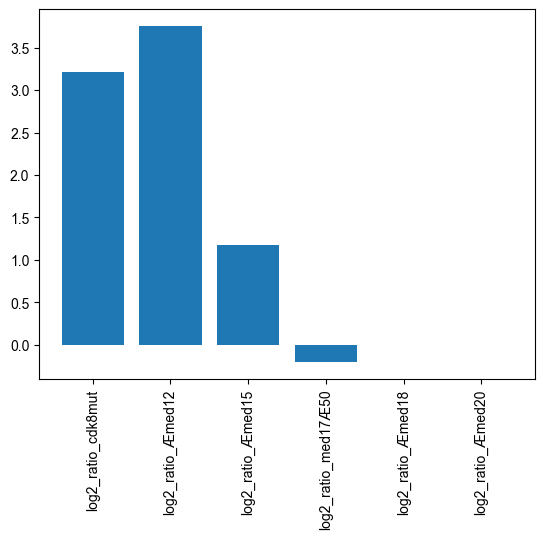

In [9]:
#full data keep Gene_Symbol column and the columns starting with log2

full_data = full_data[['Gene_Symbol'] + [col for col in full_data.columns if col.startswith('log2')]]
#plot the values for gene_symbol = SPBC317.01t
plt.bar(full_data.columns[1:], full_data[full_data['Gene_Symbol'] == 'SPBC317.01'].values[0][1:])
plt.xticks(rotation=90)
plt.show()


In [10]:
#Fold change in srb11
2**full_data[full_data['Gene_Symbol'] == 'SPBC317.01'].values[0][1]

9.260634928075994

In [11]:
2**full_data[full_data['Gene_Symbol'] == 'SPBC317.01'].values[0][2]

13.506252752635872

# Correlation between srb11 truncation and the other CKM deletions

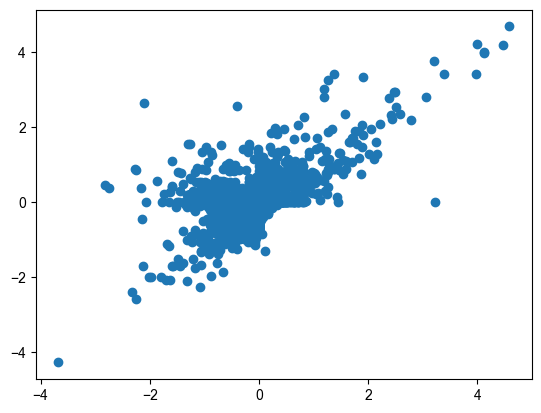

In [12]:
#scatterplot with p value over it 
plt.scatter(final["srb10"],final["med12"])

In [13]:
# Genes in srb10 and srb11, but not med12

#create a list of top 100 upregulated genes in srb10, med12 and srb11
srb10_up = list(final.sort_values(by=['srb10'],ascending=False)['gene'].head(100))
med12_up = list(final.sort_values(by=['med12'],ascending=False)['gene'].head(100))
srb11_up = list(final[(final['log2FoldChange'] > 0.5) & (final['padj'] < 0.1)].sort_values(by=['padj'],ascending=True)['gene'].head(100))
#print genes in intersection of srb10 and srb11 but not med12
print(set(srb10_up).intersection(set(srb11_up)).difference(set(med12_up)))



{'isp3', 'SPAC15E1.02c', 'SPBC19C7.04c', 'SPAC1F8.04c', 'hsp16', 'gdh2', 'eno102'}


In [14]:
%load_ext watermark
%watermark


Last updated: 2023-11-05T10:07:24.506348+00:00

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.31.1

Compiler    : Clang 11.0.0 
OS          : Darwin
Release     : 21.5.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [15]:
%watermark --iversions



matplotlib: 3.8.0
pandas    : 1.4.4
numpy     : 1.23.4

